In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag, imag, cos
from torch.linalg import matrix_exp

from IPython.display import display, Markdown

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problem Setup

Grid

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

Wavepacket

In [3]:
x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)

Non-linear, non-autonomous potentials

In [4]:
V0 = x**4 - 10*x**2

sigma = 0.5
c = 5
x0 = -2

Vt = lambda t : c * sin(5*pi*t) * x

nu = 10.
Vnl = lambda u: nu*abs(u)**2

V = lambda u, t: V0  + Vt(t) + Vnl(u)

Solver setup

In [5]:
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*V(u, t))*u    
strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

trange = [0, 1]
timegrid = es.timegrid(trange, ndt=1000)

#### Evolve

In [6]:
observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + (V0+Vt(t))*psi + Vnl(psi)*psi/2.0, u, xr), 
'position': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: (V0+Vt(t))*psi + Vnl(psi)*psi/2.0, u, xr)}

In [7]:
uT, obsvalues, uintermediate = es.solvediffeq(u, timegrid, strangstep, observables = observables, storeintermediate = True)

In [8]:
lines = lambda frame: [((x, (V0+Vt(timegrid[frame]))/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
                       ((x, imag(uintermediate[frame])), {'color':mcolors.CSS4_COLORS['gold']}, 'Im(u)'),
                       ((x, real(uintermediate[frame])), {'color':mcolors.CSS4_COLORS['yellowgreen']}, 'Re(u)'),
                       ((x, abs(uintermediate[frame])), {'color':mcolors.CSS4_COLORS['darkorange']}, '|u|')]

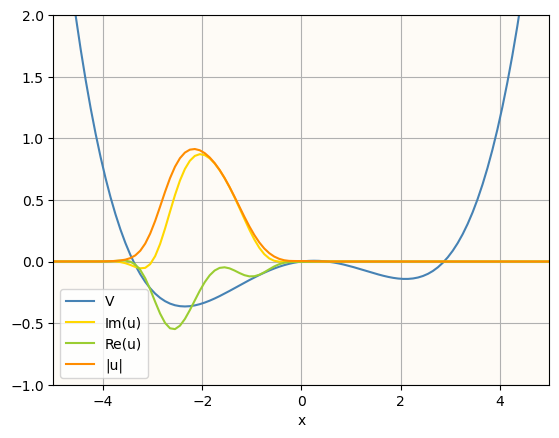

In [9]:
fig, ax = plt.subplots()
ex.plot(ax, linespecs=lines(100), xlim=[-5,5], ylim=[-1,2], xlabel='x')
plt.show()

# Animate

In [10]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=lines(frame), xlim=[-5,5], ylim=[-1,2])
outputgif = 'nonlinear_borderless.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False)
display(Markdown(f'![gif]({outputgif})'))

![gif](nonlinear_borderless.gif)

In [11]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=lines(frame), xlim=[-5,5], ylim=[-1,2], xlabel='x')
outputgif = 'nonlinear_bordered.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=True)
display(Markdown(f'![gif]({outputgif})'))

![gif](nonlinear_bordered.gif)

In [12]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=lines(frame), xlim=[-5,5], ylim=[-1,2], bgcolor=mcolors.CSS4_COLORS['darkslategray'])
outputgif = 'nonlinear_bordered_dark.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=True)
display(Markdown(f'![gif]({outputgif})'))

![gif](nonlinear_bordered_dark.gif)

In [13]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=lines(frame), xlim=[-5,5], ylim=[-1,2], bgcolor=mcolors.CSS4_COLORS['black'], grid=False, legend=False)
outputgif = 'nonlinear_borderless_black.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False)
display(Markdown(f'![gif]({outputgif})'))

![gif](nonlinear_borderless_black.gif)

#### Animate observables

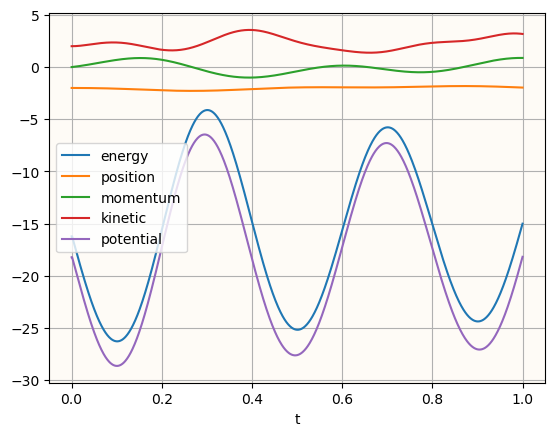

In [10]:
ex.obsplot(plt, timegrid, obsvalues)

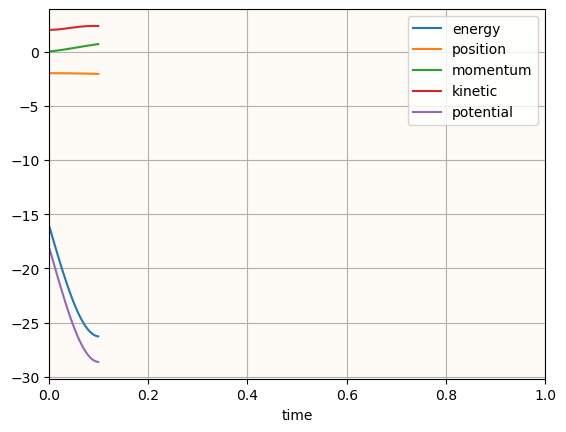

In [11]:
obslines = lambda frame: [((timegrid[:frame], obsvalues[key][0][:frame].unsqueeze(0)), {}, key) for key in obsvalues]
fig, ax = plt.subplots()
ex.plot(ax, linespecs=obslines(100), xlim=[0,timegrid[-1]], xlabel='time')
plt.show()

In [12]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=obslines(frame), xlim=[0,timegrid[-1]], ylim=[-35,5], xlabel='time')
outputgif = 'observables.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=True)
display(Markdown(f'![gif]({outputgif})'))

![gif](observables.gif)

### 2D example 1

In [2]:
n = [200, 200]
xr = [-1.5, 1.5]
[x,y] = ex.grid(n, xr)

r = torch.sqrt(x**2+y**2)
phi = torch.arctan2(y,x)

u = exp(-5*r**2)*exp(1j*3*phi)
u = ex.normalize(u, xr)     # normalize wavefunction and make it complex

V = 5e4*(r-0.2)**2

In [3]:
otmap = es.utils.colors.orangetealmap()
specsorangeteal = lambda u: [(xr, real(u), otmap, 1*abs(real(u)), 'bicubic')]

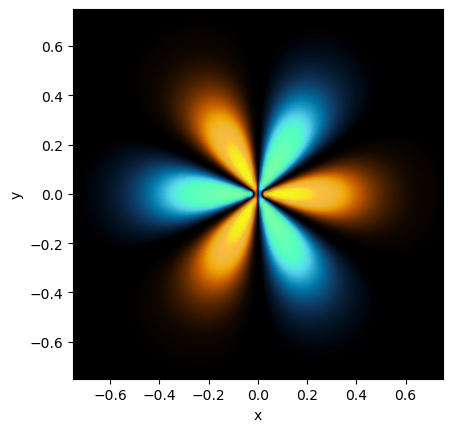

In [4]:
fig, ax = plt.subplots()
ex.imshow(ax, imspecs=specsorangeteal(u), bgcolor='black', xlim=[-0.75, 0.75], ylim=[-0.75, 0.75])
plt.show()

In [5]:
C = ex.tensorizesymbol(ex.fouriersymbol, n, xr)
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xr)
eLu = lambda t, h, c, u: ex.laplacianopexp(SL, 1j*c*h, u)
eVu = lambda t, h, c, u: exp(-1j*c*h*V)*u
strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

In [6]:
observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr) + V*psi, u, xr), 
'position x': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'position y': lambda u, t: ex.observable(lambda psi: y*psi, u, xr), 
'momentum x': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'momentum y': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(1, 1, psi, xr), u, xr), 
'angular momentum L3': lambda u, t: ex.observable(lambda psi: -1j*(x*ex.fourierproduct(C[1], psi) - y*ex.fourierproduct(C[0], psi)), u, xr),
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: V*psi, u, xr)}

In [7]:
trange = [0, 0.01]
timegrid = es.timegrid(trange, ndt=1000)
uT, obsvalues, uintermediate = es.solvediffeq(u, timegrid, strangstep, observables = observables, storeintermediate = True)

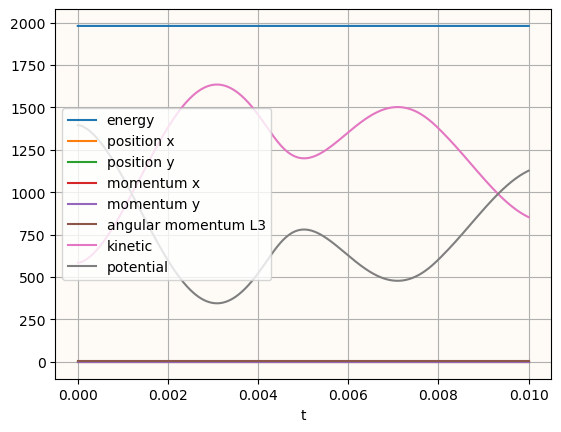

In [8]:
ex.obsplot(plt, timegrid, obsvalues)

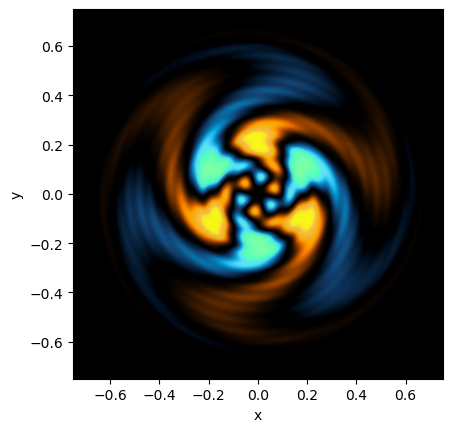

In [9]:
fig, ax = plt.subplots()
ex.imshow(ax, imspecs=specsorangeteal(uT), bgcolor='black', xlim=[-0.75, 0.75], ylim=[-0.75, 0.75])
plt.show()

In [11]:
drawframe = lambda ax, frame: ex.imshow(ax, imspecs=specsorangeteal(uintermediate[frame]), bgcolor='black', xlim=[-0.75, 0.75], ylim=[-0.75, 0.75])
outputgif = 'angular_momentum.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))

![gif](angular_momentum.gif)

### 2D example 2

In [131]:
n = [250, 200]
xr = np.array([[0, 3],[-1,2]])
[x,y] = ex.grid(n, xr)

x0 = 1.0
y0 = 0.5
kx = 10.0
ky = -5.0

sigma = 0.2
u = exp(1j*(kx*x + ky*y))*exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2))

Vmax = 100.0
V = Vmax*sin(8*pi*x)*sin(8*pi*y)*(exp(-(x-2.0)**4/0.2 - (y-0.0)**4/0.1))

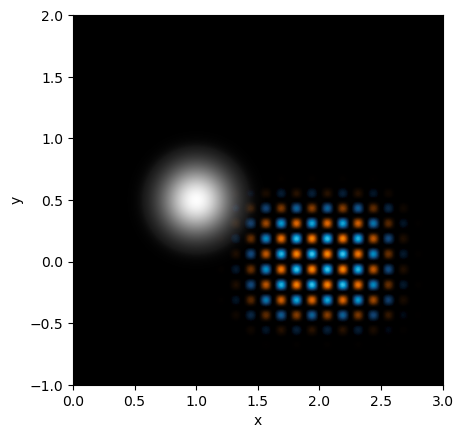

In [152]:
specsgray = lambda u: [(xr, V/(4*Vmax)+1/2, otmap, abs(V/Vmax), 'bicubic'),
                        (xr, 10*abs(u), mpl.colormaps['gray'], 1*abs(u), 'bicubic')]
fig, ax = plt.subplots()
ex.imshow(ax, imspecs=specsgray(u), bgcolor='black', xlim=xr[0], ylim=xr[1], vmin=0, vmax=1)
plt.show()

In [163]:
C = ex.tensorizesymbol(ex.fouriersymbol, n, xr)
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xr)

eps = 0.4

eLu = lambda t, h, c, u: ex.laplacianopexp(SL, 1j*c*h*eps, u)
eVu = lambda t, h, c, u: exp(-1j*c*h/eps*V)*u
strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

In [170]:
trange = [0, 0.15]
timegrid = es.timegrid(trange, ndt=1000)
uT, _, uintermediate = es.solvediffeq(u, timegrid, strangstep, observables = {}, storeintermediate = True)

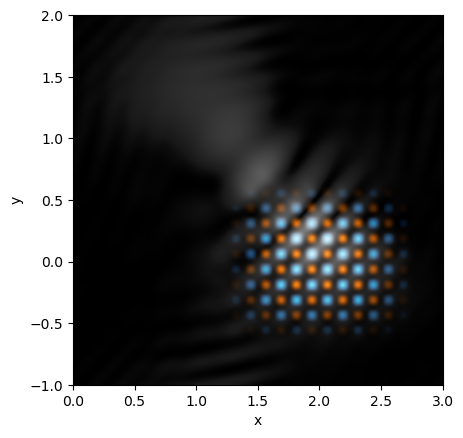

In [171]:
fig, ax = plt.subplots()
ex.imshow(ax, imspecs=specsgray(uT), bgcolor='black', xlim=xr[0], ylim=xr[1], vmin=0, vmax=1)
plt.show()

In [173]:
drawframe = lambda ax, frame: ex.imshow(ax, imspecs=specsgray(uintermediate[frame]), bgcolor='black', xlim=[0.1, 2.9], ylim=[-0.9, 1.9], vmin=0, vmax=1)
outputgif = 'lattice_scattering.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))

![gif](lattice_scattering.gif)